In [1]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from pydub import AudioSegment

DATA_DIR = pathlib.Path('data')
TEST_DIR = pathlib.Path('data/test')
seconds = None


In [2]:

# def notebook_extract(): 
#     import ipynb.fs.defs.audio_extraction as audio_extraction
#     audio_extraction.extract_zip(TEST_DIR, DATA_DIR)
#     print('-' * 50)
#     print('-' * 50)  
#     audio_extraction.rename_audio_files(DATA_DIR)

# notebook_extract()

In [3]:
def color_table(table, df=None):
    # Tabelle verschönern: Farben hinzufügen
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # Titelzeile
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#d3d3d3')  # Heller Hintergrund für die Titelzeile

        elif df is not None and i > 0 and j < len(df.columns):  # Sicherstellen, dass Spalten existieren
            if j == 0:  # Dateiname-Spalte
                cell.set_facecolor('#f0f8ff')  # Blauer Hintergrund für die Dateinamen

            elif j == 1 or j == 2:  # True Class (Spalte 1) oder Predicted Class (Spalte 2)
                true_class = df.iloc[i - 1]["True Class"]  # i-1, weil i=0 die Kopfzeile ist
                predicted_class = df.iloc[i - 1]["Predicted Class"]

                # Überprüfe, ob die Vorhersage korrekt ist
                if true_class == predicted_class:
                    cell.set_facecolor('#d4edda')  # Grün für richtig
                else:
                    cell.set_facecolor('#f8d7da')  # Rot für falsch
                cell.set_fontsize(10)

            else:  # Wahrscheinlichkeiten und andere Werte
                try:
                    if float(cell.get_text().get_text()) < 0.5:
                        cell.set_facecolor('#f8d7da')  # Rot, wenn Wahrscheinlichkeit < 0.5
                    else:
                        cell.set_facecolor('#d4edda')  # Grün, wenn Wahrscheinlichkeit >= 0.5
                except ValueError:
                    pass  # Ignoriert nicht-numerische Werte
            cell.set_fontsize(10)

    return table


In [4]:
def get_middle_chunk(file_path, chunk_length_seconds):
    audio = AudioSegment.from_file(file_path)
    chunk_length_ms = chunk_length_seconds * 1000
    total_length_ms = len(audio)
    
    if total_length_ms <= chunk_length_ms:
        return audio
    
    # Berechne den Startpunkt für den mittleren Chunk
    start_point = (total_length_ms - chunk_length_ms) // 2
    return audio[start_point:start_point + chunk_length_ms]

In [5]:

def generate_summary(results):
    total_predictions = len(results)
    correct_predictions = sum(1 for result in results if result['True Class'] == result['Predicted Class'])
    accuracy = correct_predictions / total_predictions * 100

    correct_original = sum(1 for result in results if result['True Class'] == 'original' and result['Predicted Class'] == 'original')
    correct_upscale = sum(1 for result in results if result['True Class'] == 'upscale-from-mp3-128' and result['Predicted Class'] == 'upscale-from-mp3-128')
    
    original_accuracy = correct_original / sum(1 for result in results if result['True Class'] == 'original') * 100 if sum(1 for result in results if result['True Class'] == 'original') > 0 else 0
    upscale_accuracy = correct_upscale / sum(1 for result in results if result['True Class'] == 'upscale-from-mp3-128') * 100 if sum(1 for result in results if result['True Class'] == 'upscale-from-mp3-128') > 0 else 0

    summary = {
        "Total Correct": f"{correct_predictions} / {total_predictions} ({accuracy:.2f}%)",
        "Original Accuracy": f"{original_accuracy:.2f}%",
        "Upscale Accuracy": f"{upscale_accuracy:.2f}%",
        "Overall Accuracy": f"{accuracy:.2f}%",
    }

    return summary

# Funktion zur Erstellung der Zusammenfassungs-Tabelle
def display_summary(summary):
    summary_data = [
        ["Total Correct", summary["Total Correct"]],
        ["Original Accuracy", summary["Original Accuracy"]],
        ["Upscale Accuracy", summary["Upscale Accuracy"]],
        ["Overall Accuracy", summary["Overall Accuracy"]]
    ]

    summary_df = pd.DataFrame(summary_data, columns=[f"Metric with {seconds}-sec duration", "Value"])

    fig, ax = plt.subplots(figsize=(8, 2))  # Größe der Tabelle
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc="center", loc="center", colWidths=[0.5, 0.5])
    
    color_table(table)

    plt.show()

In [6]:
def calculate_accuracy(results):
    """
    Berechnet die Anzahl korrekt und falsch klassifizierter Dateien basierend auf den Ergebnissen.
    Erwartet eine Liste von Dictionaries mit den Schlüsseln 'True Class' und 'Predicted Class'.
    """
    correct_predictions = sum(1 for result in results if result['True Class'] == result['Predicted Class'])
    total_predictions = len(results)
    accuracy = correct_predictions / total_predictions * 100
    print(f"Korrekte Vorhersagen: {correct_predictions}")
    print(f"Falsche Vorhersagen: {total_predictions - correct_predictions}")
    print(f"Genauigkeit: {accuracy:.2f}%")

In [7]:
def run(zip_file_path = "saved_models/good_models/very_good_model.zip", _seconds = 1):
    global seconds 
    seconds=_seconds
    
    # zip_file_path = "saved_models/good_models/first_good_model.zip"
    # zip_file_path = "saved_models/good_models/model_loss_0.449_acc_0.906_val_loss_0.191_val_acc_0.963.zip"
    # zip_file_path ="saved_models/good_models/model_loss_0.009_acc_1.000_val_loss_0.009_val_acc_1.000.zip"
    # zip_file_path = "saved_models/model_loss_0.168_acc_1.000_val_loss_0.742_val_acc_1.000.zip"
    
    # Entpacke das Modell
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("restored_model")
    print(f"Used Model: {zip_file_path}")    
    
    
    loaded_model = tf.saved_model.load("restored_model")
    audio_dir = "data/test"
    results = []
    print(f"Split test files in {seconds}") if seconds else print("Use complete files")

    for audio_file in os.listdir(audio_dir):
        audio_file_path = os.path.join(audio_dir, audio_file)
        
        if audio_file.endswith(".wav"):
            
            if "orig-16-44-mono" in audio_file:
                true_class = "original"
            elif "upscale-from-mp3-128" in audio_file:
                true_class = "upscale-from-mp3-128"
            else:
                raise ValueError(f"Unbekannte Klasse im Dateinamen: {audio_file}")
            
            if(seconds):
                chunk = get_middle_chunk(audio_file_path, seconds)
        
                temp_chunk_path = "restored_model/temp_chunk.wav"
                chunk.export(temp_chunk_path, format="wav")
            
                result = loaded_model(tf.constant(temp_chunk_path))
            else:
                result = loaded_model(tf.constant(audio_file_path))

            # Extrahiere Vorhersagedaten und formatiere sie auf 4 Nachkommastellen als String
            predictions = result['predictions'].numpy()[0]
            class_names = ["original", "upscale-from-mp3-128"]
            predicted_class_index = np.argmax(predictions)
            predicted_class = class_names[predicted_class_index]
            class_probabilities = {class_names[i]: f"{predictions[i]:.4f}" for i in range(len(predictions))}

            results.append({
                "Dateiname": audio_file,
                "True Class": true_class,
                "Predicted Class": predicted_class,
                **class_probabilities
            })

    os.remove(temp_chunk_path) if seconds else None
            
    # Erstelle einen DataFrame aus den Ergebnissen
    df = pd.DataFrame(results)
    # print(df)
    
    
    fig, ax = plt.subplots(figsize=(16, len(df) * 0.4))  # Breitere Tabelle für längere Dateinamen
    ax.axis('tight')
    ax.axis('off')

    # Formatieren der Zellen als Strings mit 4 Dezimalstellen
    cell_text = [
        [f"{value:.4f}" if isinstance(value, (float, int)) else str(value) for value in row]
        for row in df.values
    ]

    # Dynamische Anpassung der Spaltenbreiten
    table = ax.table(
        cellText=cell_text,
        colLabels=df.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.5] + [0.25] * (len(df.columns) - 1)
    )

    table = color_table(table, df)

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) 
    plt.show()
    
    summary = generate_summary(results)
    display_summary(summary)

# Test Model

Used Model: saved_models/good_models/very_good_model.zip
Split test files in 1


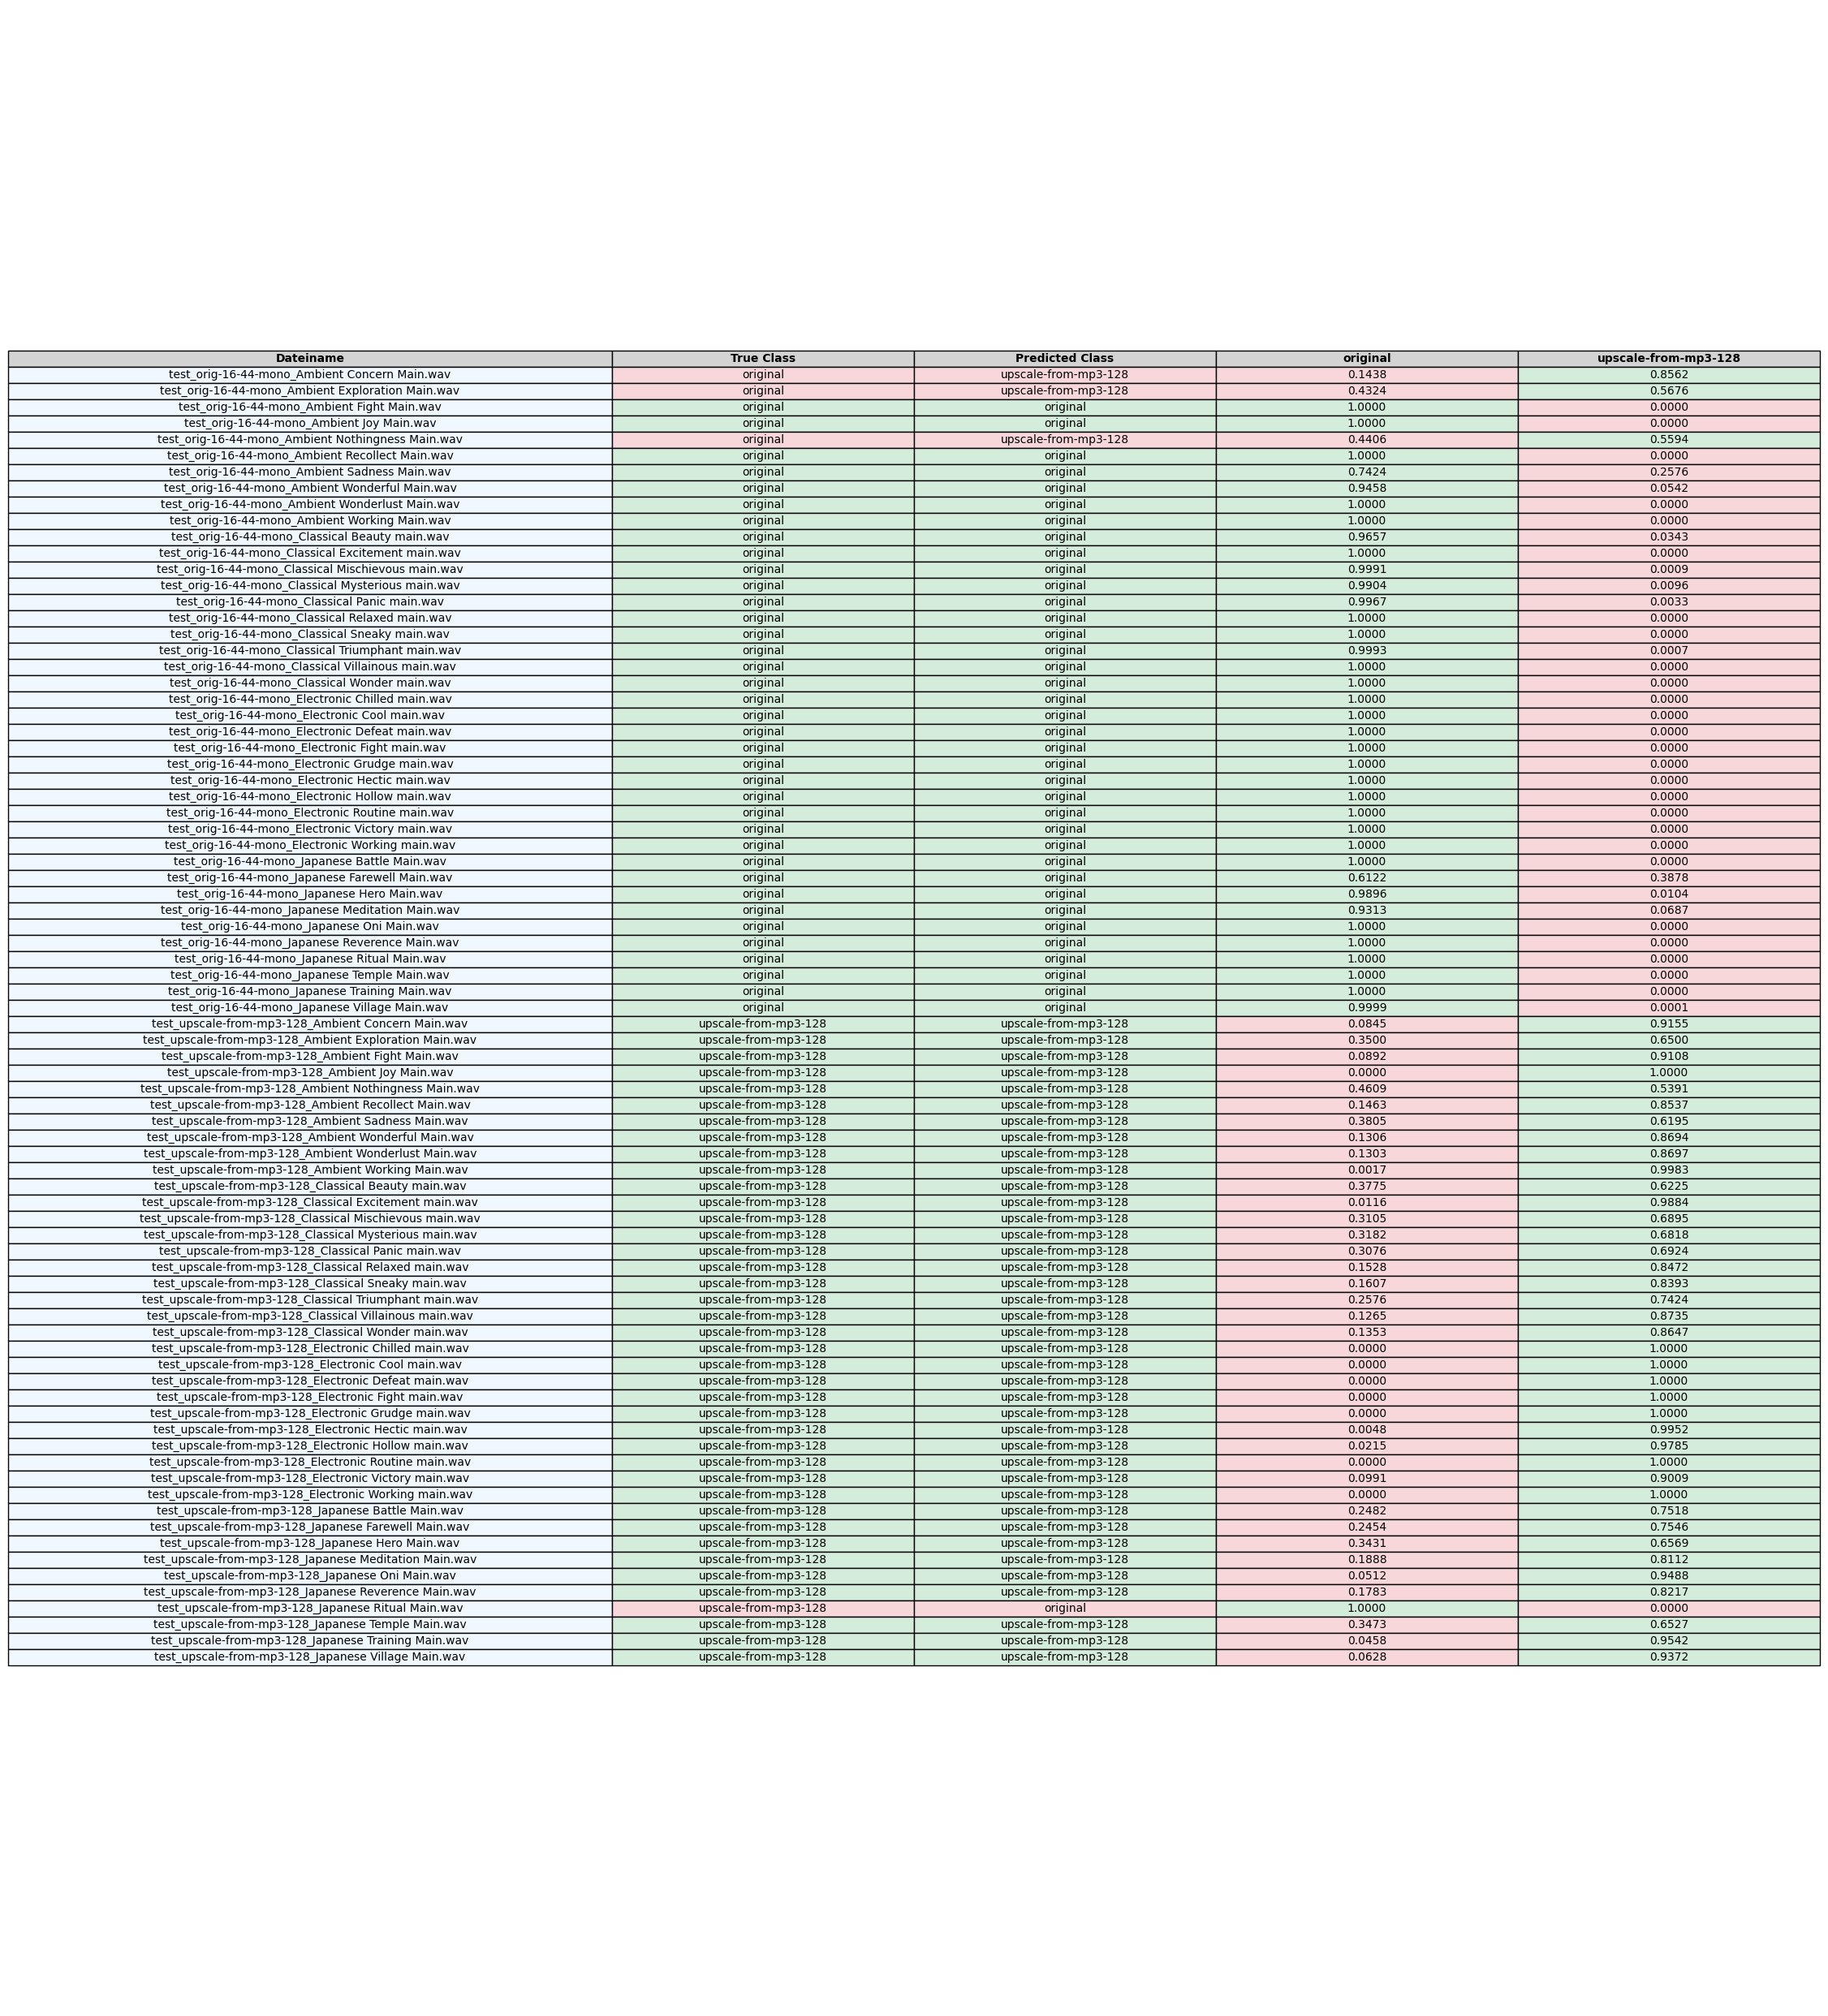

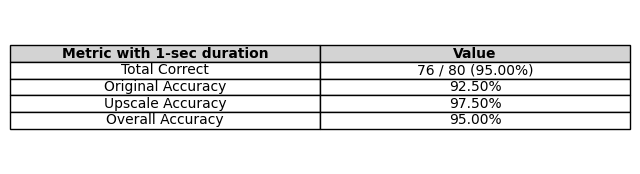

In [8]:
run()